#### BreastCancerClassifier
#### Table of Content
[1.1Scikit-Learn](#transc_data)

[1.1.1General Classifier](#general)

[1.1.2Cross Validation](#CV_general)

[1.1.3Prediction](#Pred_general)

[1.1.4ROC Curve](#ROC_general)

[1.1.5Learning Curve](#LR_general)

[1.2.1Ensemble:Voting](#voting)

[1.3.1Ensemble:Tree](#ensemble_tree)

[2.1xgboost](#xgboost)

[3.1lightGBM](#lightgbm)

[4.1DeepLearning:TensorFlow](#tf)

In [17]:
%matplotlib inline
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as gbm
from lightgbm import LGBMClassifier

import xgboost as xgb
from xgboost import XGBClassifier

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV, StratifiedKFold, learning_curve, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, auc, accuracy_score, f1_score, classification_report

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.svm import SVC

In [2]:
data = pd.read_csv('data/breastCancer.csv')

#### Overview
699 entries, 10 columns
#### columns summary
- id : unique id
- feature : numerical rating from 1-10 ['clump_thickness', 'size_uniformity', 'shape_uniformity','marginal_adhesion', 'epithelial_size', 'bare_nucleoli','bland_chromatin', 'normal_nucleoli', 'mitoses']
- class : {2:benign, 4:malignant}

In [3]:
##fillna
bn_mean = np.floor(np.mean(np.int64(data.bare_nucleoli[data.bare_nucleoli!="?"])))
data.replace('?', bn_mean, inplace=True)
data = data.applymap(np.float64)

In [4]:
feature_cols = ['clump_thickness', 'size_uniformity', 'shape_uniformity','marginal_adhesion', 'epithelial_size', 'bare_nucleoli','bland_chromatin', 'normal_nucleoli', 'mitoses']
classes = {2:0,4:1}
data['binary_class'] = data['class'].map(classes)
X = data[feature_cols].values
Y = data['binary_class'].values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

In [5]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
scaler = StandardScaler()
kfold = StratifiedKFold(n_splits=10)
random_state = 2
MLP_params = {'hidden_layer_sizes':(20,),'solver': 'adam', 'learning_rate_init': 0.01,'max_iter':1000}
classifiers = []
classifiers.append(SVC(kernel="linear", C=0.025,probability=True,random_state=random_state)) #predict_proba available when probability=True
classifiers.append(SVC(gamma=2, C=1,probability=True,random_state=random_state))#predict_proba
classifiers.append(DecisionTreeClassifier(random_state=random_state)) #predict_proba
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state)) #predict_proba
classifiers.append(ExtraTreesClassifier(random_state=random_state)) #predict_proba
classifiers.append(GradientBoostingClassifier(random_state=random_state)) #predict_proba
classifiers.append(MLPClassifier(random_state=random_state,**MLP_params)) #predict_proba
classifiers.append(KNeighborsClassifier()) #predict_proba
classifiers.append(LogisticRegression(random_state = random_state)) #predict_proba
classifiers.append(LinearDiscriminantAnalysis()) #predict_proba
classifiers.append(GaussianProcessClassifier(1.0 * RBF(1.0))) #predict_proba
start = time.time()
cv_results = []
for classifier in classifiers :
    c_start = time.time()
    print (classifier)
    cv_results.append(cross_val_score(classifier, scaler.fit_transform(X_train), y = Y_train, scoring = 'f1', cv = kfold, n_jobs=-1))
    c_time = time.time()-c_start
    print ('time: {:f}'.format(c_time))
tot_time = time.time()-start
print ('total_time: {:f}'.format(tot_time))
cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

SVC(C=0.025, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=2, shrinking=True, tol=0.001,
  verbose=False)
time: 0.227503
SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=2, kernel='rbf',
  max_iter=-1, probability=True, random_state=2, shrinking=True, tol=0.001,
  verbose=False)
time: 0.238761
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=2,
            splitter='best')
time: 0.231315
AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=No

In [6]:
cv_res = pd.DataFrame({"CrossValF1Means":cv_means,"CrossValerrors": cv_std,\
                       "Algorithm":["SVC_lm","SVC_rbf","DecisionTreeClassifier","AdaBoostClassifier","RandomForestClassifier",
             "ExtraTreesClassifier","GradientBoostingClassifier","MLPClassifier",'KNeighborsClassifier',
            'LogisticRegression','LinearDiscriminantAnalysis','GaussianProcessClassifier']})
cv_res.sort_values('CrossValF1Means',ascending=False).head()

,Algorithm,CrossValF1Means,CrossValerrors
0,SVC_lm,0.947290,0.045661
8,KNeighborsClassifier,0.946702,0.049542
9,LogisticRegression,0.946300,0.036937
11,GaussianProcessClassifier,0.946300,0.036937
5,ExtraTreesClassifier,0.943394,0.036131


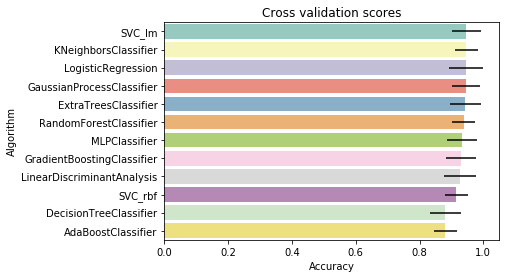

In [7]:
g = sns.barplot("CrossValF1Means","Algorithm",data = cv_res.sort_values('CrossValF1Means',ascending=False), palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Accuracy")
g = g.set_title("Cross validation scores")

In [8]:
plt.figure(figsize=(12,12))
algrithm = ["SVC_lm","SVC_rgb","DecisionTreeClassifier","AdaBoostClassifier","RandomForestClassifier",
             "ExtraTreesClassifier","GradientBoostingClassifier","MLPClassifier",'KNeighborsClassifier',
            'LogisticRegression','LinearDiscriminantAnalysis','GaussianProcessClassifier']
ROCurve = dict()
cv_res["Accuracy"]=0
for n, classifier in enumerate(classifiers):
    name = algrithm[n]
    classifier.fit(scaler.transform(X_train),Y_train)
    probs = classifier.predict_proba(scaler.transform(X_test))
    preds = probs[:,1]
    fpr, tpr, threshold = roc_curve(Y_test, preds)
    roc_auc = auc(fpr, tpr)
    ROCurve[name]=(fpr,tpr,roc_auc)
    acc = accuracy_score(Y_test,classifier.predict(scaler.transform(X_test)))
    cv_res.loc[n,"Accuracy"] = acc
cv_res.sort_values('Accuracy',ascending=False).head()

,Algorithm,CrossValF1Means,CrossValerrors,Accuracy
0,SVC_lm,0.947290,0.045661,0.978571
4,RandomForestClassifier,0.938577,0.049179,0.978571
5,ExtraTreesClassifier,0.943394,0.036131,0.971429
6,GradientBoostingClassifier,0.930375,0.046785,0.971429
7,MLPClassifier,0.934538,0.046075,0.971429


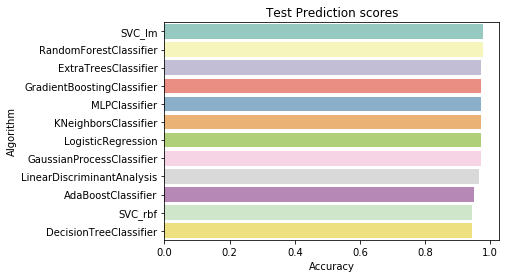

In [9]:
g = sns.barplot("Accuracy","Algorithm",data = cv_res.sort_values('Accuracy',ascending=False), palette="Set3",orient = "h")
g.set_xlabel("Accuracy")
g = g.set_title("Test Prediction scores")

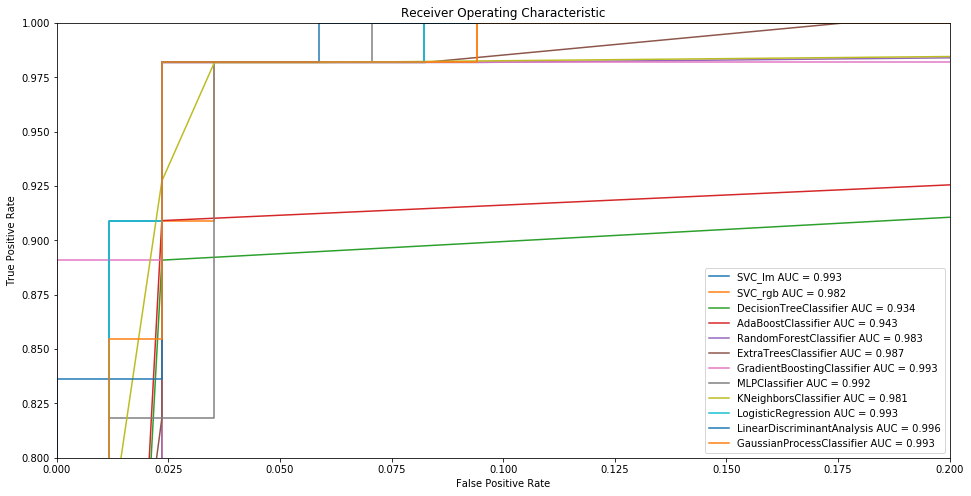

In [10]:
plt.figure(figsize=(16,8))
for C in ROCurve:
    #ROCurve[name]=(fpr,tpr,roc_auc)
    plt.plot(ROCurve[C][0], ROCurve[C][1], label = '{:s} AUC = {:.3f}'.format(str(C),ROCurve[C][2]))
plt.title('Receiver Operating Characteristic')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 0.2])
plt.ylim([0.8, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [11]:
###Learning Curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=None, n_jobs=n_jobs, train_sizes=train_sizes, scoring='f1', verbose = 0)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [12]:
### Voting 
voting_estimators=["SVC_lm","RandomForestClassifier",'GaussianProcessClassifier','KNeighborsClassifier','LogisticRegression']
estimators = list()
for n,c in enumerate(algrithm):
    if c in voting_estimators:
        estimators.append((c,classifiers[n]))   
votingC = VotingClassifier(estimators=estimators, voting='soft', n_jobs=-1)
votingC = votingC.fit(scaler.transform(X_train), Y_train)
y_pred = votingC.predict(scaler.transform(X_test))
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(Y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 97.86%


/home/yhh281/anaconda2/envs/pydata/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


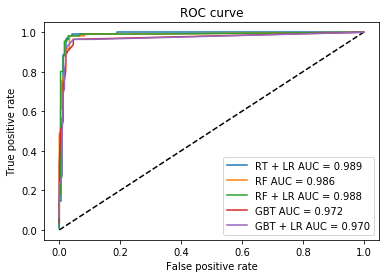

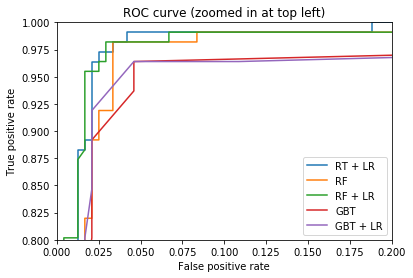

In [13]:
### Ensemble of Trees
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomTreesEmbedding
from sklearn.pipeline import make_pipeline
scaler = StandardScaler()
n_estimator = 10
X = data[feature_cols].values
Y = data['binary_class'].values
X_train, X_test, y_train, y_test = train_test_split(scaler.fit_transform(X), Y, test_size=0.5)
# It is important to train the ensemble of trees on a different subset
# of the training data than the linear regression model to avoid
# overfitting, in particular if the total number of leaves is
# similar to the number of training samples
X_train, X_train_lr, y_train, y_train_lr = train_test_split(X_train,
                                                            y_train,
                                                            test_size=0.5)

# Unsupervised transformation based on totally random trees
rt = RandomTreesEmbedding(max_depth=3, n_estimators=n_estimator,
    random_state=0)

rt_lm = LogisticRegression()
pipeline = make_pipeline(rt, rt_lm)
pipeline.fit(X_train, y_train)
y_pred_rt = pipeline.predict_proba(X_test)[:, 1]
fpr_rt_lm, tpr_rt_lm, _ = roc_curve(y_test, y_pred_rt)
auc_rt_lm = auc(fpr_rt_lm, tpr_rt_lm)

# Supervised transformation based on random forests
rf = RandomForestClassifier(max_depth=3, n_estimators=n_estimator)
rf_enc = OneHotEncoder()
rf_lm = LogisticRegression()
rf.fit(X_train, y_train)
rf_enc.fit(rf.apply(X_train))
rf_lm.fit(rf_enc.transform(rf.apply(X_train_lr)), y_train_lr)

y_pred_rf_lm = rf_lm.predict_proba(rf_enc.transform(rf.apply(X_test)))[:, 1]
fpr_rf_lm, tpr_rf_lm, _ = roc_curve(y_test, y_pred_rf_lm)
auc_rf_lm = auc(fpr_rf_lm, tpr_rf_lm)

grd = GradientBoostingClassifier(n_estimators=n_estimator)
grd_enc = OneHotEncoder()
grd_lm = LogisticRegression()
grd.fit(X_train, y_train)
grd_enc.fit(grd.apply(X_train)[:, :, 0])
grd_lm.fit(grd_enc.transform(grd.apply(X_train_lr)[:, :, 0]), y_train_lr)

y_pred_grd_lm = grd_lm.predict_proba(
    grd_enc.transform(grd.apply(X_test)[:, :, 0]))[:, 1]
fpr_grd_lm, tpr_grd_lm, _ = roc_curve(y_test, y_pred_grd_lm)
auc_grd_lm = auc(fpr_grd_lm, tpr_grd_lm)

# The gradient boosted model by itself
y_pred_grd = grd.predict_proba(X_test)[:, 1]
fpr_grd, tpr_grd, _ = roc_curve(y_test, y_pred_grd)
auc_grd = auc(fpr_grd, tpr_grd)

# The random forest model by itself
y_pred_rf = rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
auc_rf = auc(fpr_rf, tpr_rf)
'{:s} AUC = {:.3f}'.format(str(C),ROCurve[C][2])
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rt_lm, tpr_rt_lm, label='RT + LR AUC = {:.3f}'.format(auc_rt_lm))
plt.plot(fpr_rf, tpr_rf, label='RF AUC = {:.3f}'.format(auc_rf))
plt.plot(fpr_rf_lm, tpr_rf_lm, label='RF + LR AUC = {:.3f}'.format(auc_rf_lm))
plt.plot(fpr_grd, tpr_grd, label='GBT AUC = {:.3f}'.format(auc_grd))
plt.plot(fpr_grd_lm, tpr_grd_lm, label='GBT + LR AUC = {:.3f}'.format(auc_grd_lm))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rt_lm, tpr_rt_lm, label='RT + LR')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_rf_lm, tpr_rf_lm, label='RF + LR')
plt.plot(fpr_grd, tpr_grd, label='GBT')
plt.plot(fpr_grd_lm, tpr_grd_lm, label='GBT + LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

In [14]:
###xgboost
from xgboost import XGBClassifier
X = data[feature_cols].values
Y = data['binary_class'].values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20, random_state = 0)
xgb = XGBClassifier()
xgb.fit(scaler.transform(X_train), Y_train)
y_pred = xgb.predict(scaler.transform(X_test))
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(Y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 97.86%


/home/yhh281/anaconda2/envs/pydata/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [15]:
###lightGBM
from lightgbm import LGBMClassifier
gbm = LGBMClassifier()
gbm.fit(scaler.transform(X_train), Y_train)
y_pred = gbm.predict(scaler.transform(X_test))
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(Y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 97.14%


/home/yhh281/anaconda2/envs/pydata/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [16]:
###TensorFlow
from keras.optimizers import SGD
DNN = Sequential()
DNN.add(Dense(32,activation='linear',input_dim=9))
DNN.add(Dense(16,activation='relu'))
DNN.add(Dense(8,activation='relu'))
DNN.add(Dense(1,activation='sigmoid'))
#sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
DNN.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
DNN.fit(scaler.transform(X_train), Y_train, epochs=10, batch_size=16)
y_pred = DNN.predict(scaler.transform(X_test))
predictions = [round(value) for value in y_pred[:,0]]
accuracy = accuracy_score(Y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Epoch 1/10
559/559 [==============================] - 0s 273us/step - loss: 0.3096 - acc: 0.9088
Epoch 2/10
559/559 [==============================] - 0s 61us/step - loss: 0.1257 - acc: 0.9642
Epoch 3/10
559/559 [==============================] - 0s 61us/step - loss: 0.0874 - acc: 0.9732
Epoch 4/10
559/559 [==============================] - 0s 61us/step - loss: 0.0793 - acc: 0.9714
Epoch 5/10
559/559 [==============================] - 0s 61us/step - loss: 0.0759 - acc: 0.9732
Epoch 6/10
559/559 [==============================] - 0s 62us/step - loss: 0.0728 - acc: 0.9750
Epoch 7/10
559/559 [==============================] - 0s 61us/step - loss: 0.0713 - acc: 0.9750
Epoch 8/10
559/559 [==============================] - 0s 61us/step - loss: 0.0693 - acc: 0.9750
Epoch 9/10
559/559 [==============================] - 0s 63us/step - loss: 0.0678 - acc: 0.9767
Epoch 10/10
559/559 [==============================] - 0s 65us/step - loss: 0.0664 - acc: 0.9767
Accuracy: 97.14%
